# PG3 Group-Finding Optimization for 100% Spec-z Dataset

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

catalog_name_template = '/srv/one/zhutchen/paper3/catalogs/ECOgroupcat_{num}.csv'
parameter_file = '/srv/one/zhutchen/paper3/catalogs/parameter_combinations.csv'

## Read Parameter File & Extract Statistics

In [2]:
names = ['id','sigmacz','Pth_values', 'rproj_values', 'vproj_values', 'offset_values', 'gdrproj_values', 'gdvproj_values', 'gdoffset_values']
params = np.genfromtxt(parameter_file, names=names)

In [3]:
exclude_Neq1 = False
statistic = np.mean

In [4]:
cbar_tr = np.zeros(len(params))
cbar_rt = np.zeros(len(params))
pbar_tr = np.zeros(len(params))
pbar_rt = np.zeros(len(params))

for ii in tqdm(range(0,len(params))):
    try:
        catalog = pd.read_csv(catalog_name_template.format(num=params['id'][ii]))
        catalog = catalog[(catalog.absrmag<=-17.33)]
        if exclude_Neq1:
            raise ValueError("not yet supported...")
        else:
            catalog = catalog.groupby('pg3grp').first()

        cbar_tr[ii] = statistic(catalog.C_TR)
        cbar_rt[ii] = statistic(catalog.C_RT)
        pbar_tr[ii] = statistic(catalog.P_TR)
        pbar_rt[ii] = statistic(catalog.P_RT)
        del catalog
    except FileNotFoundError:
        print('no file', ii, params[ii])
    
ptimesc_rt = pbar_rt * cbar_rt
ptimesc_tr = pbar_tr * cbar_tr

100%|█████████████████████████████████████████| 300/300 [04:20<00:00,  1.15it/s]


In [5]:
params = pd.DataFrame(params)

In [6]:
params.loc[:,'ptimesc_rt'] = ptimesc_rt
params.loc[:,'ptimesc_tr'] = ptimesc_tr
params.loc[:,'cbar_tr'] = cbar_tr
params.loc[:,'cbar_rt'] = cbar_rt
params.loc[:,'pbar_tr'] = pbar_tr
params.loc[:,'pbar_rt'] = pbar_rt

## Make Plot (like Fig. 10 in H23)

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from matplotlib.colors import LogNorm
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 9
rcParams['font.family'] = 'sans-serif'
rcParams['grid.color'] = 'k'
rcParams['grid.linewidth'] = 0.2
my_locator = MaxNLocator(6)
singlecolsize = (3.3522420091324205, 2.0717995001590714)
doublecolsize = (7.100005949910059, 4.3880449973709)

def make_xlabels(combos):
    labels=[]
    for combo in combos:
        #label = [f"{pp:0.2f}," for pp in combo]
        #label=' '.join(label)
        label = "({:0.2f},{:0.1f},{:0.1f},{:0.0f},{:0.1f},{:0.1f},{:0.0f})".format(*combo)
        labels.append(label)
    return labels

In [10]:
ptimesc_tr_label = r'$\bar{P}_{TR} \times \bar{C}_{TR}$'
ptimesc_rt_label = r'$\bar{P}_{RT} \times \bar{C}_{RT}$'
p_tr_label = r'$\bar{P}_{TR}$'
c_tr_label = r'$\bar{C}_{TR}$'
p_rt_label = r'$\bar{P}_{RT}$'
c_rt_label = r'$\bar{C}_{RT}$'

ylim = (0.84,1)
labelfontsize=7
labelrotation=45
figylabel = "Purity or Completeness Statistic"
figxlabel = "Group Finding Parameters"

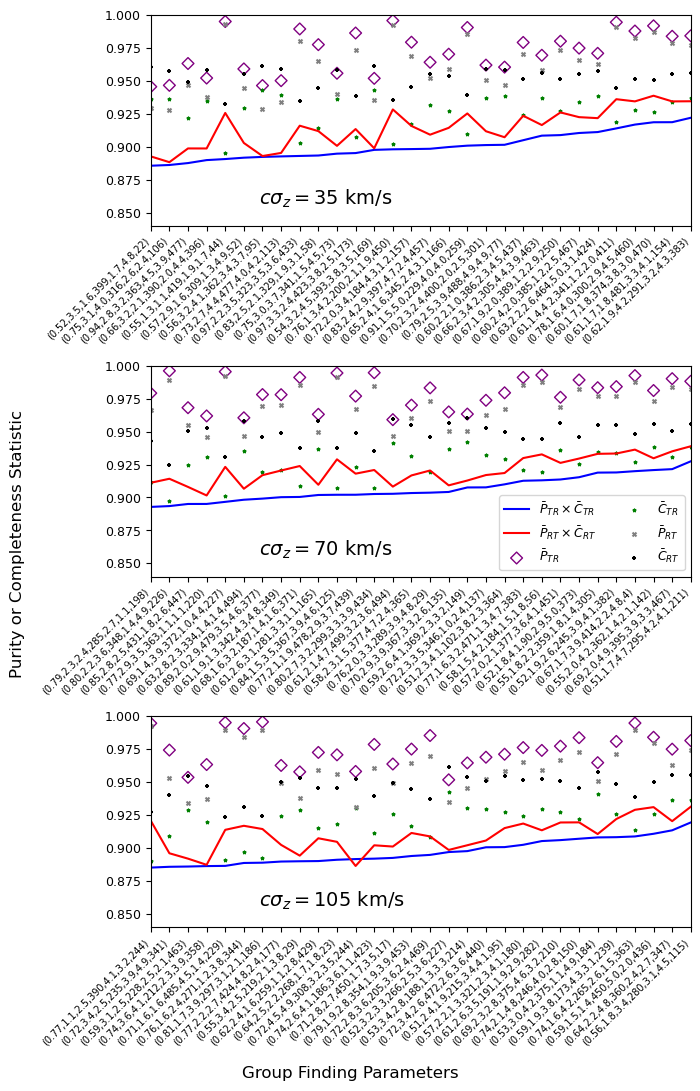

In [15]:
unique_sigmacz = np.unique(params['sigmacz'])
fig, axs = plt.subplots(nrows = len(unique_sigmacz), figsize=(1*doublecolsize[0], 2.5*doublecolsize[1]))
id_opt=list()

for ii,usig in enumerate(unique_sigmacz):
    sel = (params['sigmacz'] == usig)
    tmp = params[sel].sort_values(by='ptimesc_tr').tail(30)
    dummy = np.arange(len(tmp))
    
    axs[ii].plot(dummy,tmp.ptimesc_tr, label=ptimesc_tr_label, color='blue')
    axs[ii].plot(dummy,tmp.ptimesc_rt, label=ptimesc_rt_label, color='red')
    axs[ii].scatter(dummy,tmp.pbar_tr,label=p_tr_label, marker='D', edgecolor='purple', facecolor='None')
    axs[ii].scatter(dummy,tmp.cbar_tr,label=c_tr_label,marker='*', color='green', s=5)
    axs[ii].scatter(dummy,tmp.pbar_rt,label=p_rt_label,marker='x',color='gray', s=8)
    axs[ii].scatter(dummy,tmp.cbar_rt,label=c_rt_label,marker='+',color='k', s=8)
    axs[ii].annotate(xy=(0.2,0.1),text=r'$c\sigma_z=$'+f"{usig:0.0f} km/s", xycoords='axes fraction', fontsize=14)
    
    keys = ['Pth_values','rproj_values','vproj_values','offset_values', 'gdrproj_values', 'gdvproj_values','gdoffset_values']
    combos = (tmp[keys].to_numpy())
    xlabels = make_xlabels(combos)
    #xlabels = tmp.id.astype(str)
    axs[ii].set_xticks(dummy, labels=xlabels, rotation=labelrotation, fontsize=labelfontsize, ha=('right' if (labelrotation>0 and labelrotation<90) else 'center'))
    
    axs[ii].set_ylim(*ylim)
    axs[ii].set_xlim(dummy.min(),dummy.max())
    
    id_opt.append(tmp.loc[tmp.ptimesc_tr.idxmax(),'id'])
    
axs[1].legend(loc='lower right', ncol=2)
fig.supylabel(figylabel)
fig.supxlabel(figxlabel)
plt.tight_layout()
plt.show()

In [118]:
for idv in id_opt:
    print(params.loc[params.id==idv,:])
    print("# ===================================== #")

      id  sigmacz  Pth_values  rproj_values  vproj_values  offset_values  \
49  49.0     35.0    0.624288       1.87374       4.19218        290.954   

    gdrproj_values  gdvproj_values  gdoffset_values  ptimesc_rt  ptimesc_tr  \
49          3.1688         4.34483           383.49    0.934557     0.92204   

     cbar_tr   cbar_rt   pbar_tr   pbar_rt  
49  0.936851  0.955991  0.984191  0.977579  
# ===================================== #
        id  sigmacz  Pth_values  rproj_values  vproj_values  offset_values  \
185  185.0     70.0    0.510102        1.6667       4.67827        294.739   

     gdrproj_values  gdvproj_values  gdoffset_values  ptimesc_rt  ptimesc_tr  \
185         4.21742         4.13225          211.281     0.93886    0.927451   

      cbar_tr   cbar_rt   pbar_tr  pbar_rt  
185  0.938616  0.955447  0.988105  0.98264  
# ===================================== #
        id  sigmacz  Pth_values  rproj_values  vproj_values  offset_values  \
264  264.0    105.0    0.559